In [1]:
#import sklearn 
import numpy as np
from osgeo import gdal, gdal_array
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os.path
import pathlib
import platform 
import json 
import geopandas as gpd
from shapely.geometry import Point
from pykrige.ok import OrdinaryKriging
import matplotlib as mpl
import rasterio
from rasterio.transform import from_origin
from rasterio.enums import Resampling
import imageio.v2 as imageio
import xarray as xr
from rasterio import features
from rasterio.plot import show

In [2]:
cwd = pathlib.Path().resolve()
src = cwd.parent
data = src.parent.parent.parent
OS_type = platform.system()

if OS_type == 'Darwin':
    username = 'Mats '
    data_path = os.path.join(data, 'data_tana', 'TAHMO', 'location_tahmo')
    data_path_location = os.path.join(data, 'data_tana')
    
else:
    username = 'Mootje'
    data_path = os.path.join(data, 'OneDrive - Delft University of Technology', 'TU Delft', 'Master ENVM', 'MDP', 'Model', 'Data', 'TAHMO')
    data_path_location = os.path.join(data, 'OneDrive - Delft University of Technology', 'TU Delft', 'Master ENVM', 'MDP', 'Model', 'Data')

print(f"Welcome {username}, have a wonderful day on your {OS_type} machine. Your data should be located in {data_path}")

Welcome Mats , have a wonderful day on your Darwin machine. Your data should be located in /Users/matskerver/Documents/data_tana/TAHMO/location_tahmo


In [3]:
data_files = glob.glob(os.path.join(data_path, '*.csv'))

dataframes = {}

for file in data_files:
    station_name = os.path.splitext(os.path.basename(file))[0].split('_')[0]
    df = pd.read_csv(file, index_col = 0, sep =',', parse_dates = True)
    dataframes[station_name] = df
    
print(dataframes)

{'location':                 pr    te_mean  te_max  te_min    ra_mean  longitude  latitude
Timestamp                                                                    
2020-12-01   0.000  25.206122    28.4    23.2  36.218821  38.369665  -2.67199
2020-12-02  15.831  24.933681    29.5    21.2  36.198983  38.369665  -2.67199
2020-12-03  12.719  23.139236    29.7    21.3  36.180251  38.369665  -2.67199
2020-12-04   0.136  24.223611    29.7    21.2  36.162656  38.369665  -2.67199
2020-12-05   0.085  25.320486    31.4    21.7  36.146230  38.369665  -2.67199
...            ...        ...     ...     ...        ...        ...       ...
2023-12-27   0.102  25.737500    31.2    21.9  36.106428  38.369665  -2.67199
2023-12-28   0.102  26.395833    32.0    22.5  36.119712  38.369665  -2.67199
2023-12-29   0.102  26.271875    31.4    21.2  36.134339  38.369665  -2.67199
2023-12-30   0.102  26.180208    31.6    23.0  36.150293  38.369665  -2.67199
2023-12-31   0.000  23.100000    23.1    23.1  36.1

In [4]:
proj = 'EPSG:32737'

In [5]:
counties = gpd.read_file(os.path.join(data_path, 'total_tana_catchement_area_clip_projected.gpkg'))
geo_dataframes = {}

for key in dataframes:
    geometry = [Point(xy) for xy in zip(dataframes[key]['longitude'], dataframes[key]['latitude'])]
    rain_gdf = gpd.GeoDataFrame(dataframes[key], geometry=geometry)
    geo_dataframes[key] = rain_gdf
    
#print(geo_dataframes)

Text(0.5, 1.0, 'Tana Basin Area Kenya')

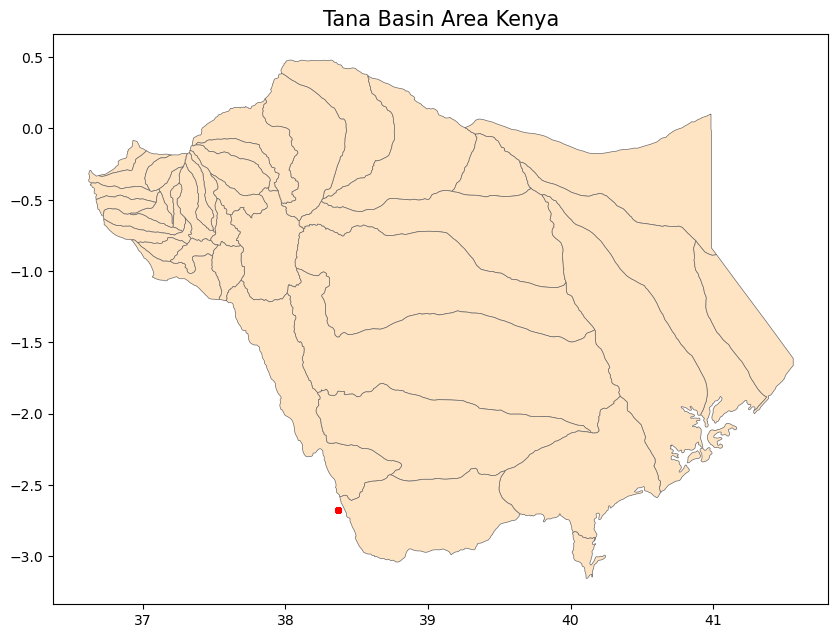

In [6]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# Stylize plots
plt.style.use('bmh')

# Plot data
counties.plot(ax = ax, color = 'bisque', edgecolor = 'dimgray')

for key in geo_dataframes:
    geo_dataframes[key].plot(ax = ax, marker = 'o', color = 'red', markersize = 15)
#rain_test_gdf.plot(ax = ax, marker = 'o', color = 'royalblue', markersize = 3)
# Set title
ax.set_title('Tana Basin Area Kenya', fontdict = {'fontsize': '15', 'fontweight' : '3'})

In [7]:
#Warning! creates a file of multiple gb (about 6.5Gb for grid_space = 0.01)
netCDF_file = True 

if (netCDF_file == True):
    
    #Reads in the required datasets and shapefiles to use the Kriging interpolation on.
    ds = xr.open_dataset(os.path.join(data_path, 'weather_data_TAHMO.nc'))
    path_shape = os.path.join(data_path, 'total_tana_catchement_area_clip.shp')
    shapefile = gpd.read_file(path_shape)
    
    #Variables that determine the grid resolution (in degrees longitude and latitude) and the extend of the earth 
    #to be plotted (same units).
    grid_space = 1
    variable = 'te_mean'
    longitudes_mapped = [36, 42]
    latitudes_mapped = [-4, 2]
    
    grid_lons = np.arange(longitudes_mapped[0], longitudes_mapped[1], grid_space)
    grid_lats = np.arange(latitudes_mapped[0], latitudes_mapped[1], grid_space)

    #Extract the station, location and variable data from the dataset ds
    latitudes = ds.sel(variable='latitude').to_array().mean(dim='time').values
    longitudes = ds.sel(variable='longitude').to_array().mean(dim='time').values
    station_ids = ds.sel(variable='latitude').to_array().mean(dim='time').coords['variable'].values
    variable_data = ds.sel(variable=variable)

    # Create empty variable to store the grids in and a variable to keep track of the progress of the interpolation.
    # Variable interval determines the timesteps on which the progess will be printed.
    z_values = []
    progress = 0
    interval = 25
    
    
    # ------------- Don't Change anything beneath this line. Variables should be changed above -------------- #

    
    #We loop through each of the timesteps in the provided netcdf file.
    for time_value in ds.time:
        
        #Empty array is created to store the current data variable to be interpolated on the grid
        data = []
        for station in ds.data_vars:
            # Select the data for the current time and variable of interest
            value = ds[station].sel(time=time_value, variable=variable).values
            data.append(value.item() if value.size > 0 else np.nan)
        
        # Convert the data to a numpy array so we can apply a mask. As some stations have gaps in their data we 
        # need to exclude these to prevent errors. This is done with the Mask. We also need to remove the longitudes
        # and latitudes of these points to ensure consistent array dimensions. 
        
        data = np.array(data)
        valid_mask = ~np.isnan(data)
        filtered_data = data[valid_mask]
        filtered_longitudes = longitudes[valid_mask]
        filtered_latitudes = latitudes[valid_mask]

        # Setup the Ordinary Kriging interpolator and subsequently execute it. It is then added to the array.
        OK = OrdinaryKriging(
            filtered_longitudes,
            filtered_latitudes,
            filtered_data,
            variogram_model='gaussian',
            verbose=False,
            enable_plotting=False
        )
        z, ss = OK.execute('grid', grid_lons, grid_lats)
        z_values.append(z)
        
        # Keep the user updated on the progress of the interpolation process as it can take significant time.
        if (i % interval == 0):
            print(i)
        i += 1

        
    # Put all the data back into a suitable Xarray to be converted into the final NetCDF file
    z_array = np.stack(z_values)

    time_dim = ds.time 
    lon_dim = np.arange(longitudes_mapped[0], longitudes_mapped[1], grid_space)  # Longitude grid
    lat_dim = np.arange(latitudes_mapped[0], latitudes_mapped[1], grid_space)  # Latitude grid
    kriging_ds = xr.Dataset(
        {
            'z': (['time', 'latitude', 'longitude'], z_array)
        },
        coords={
            'time': time_dim,
            'latitude': lat_dim,
            'longitude': lon_dim
        }
    )

    #kriging_ds.to_netcdf('kriging_results.nc')

UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

In [ ]:
cdict = {
        'red':   [(0.0, 1.0, 1.0), (0.05, 0.59, 0.59), (1.0, 0.0, 0.0)],
        'green': [(0.0, 1.0, 1.0), (0.05, 0.29, 0.29), (0.2, 1.0, 1.0), (1.0, 0.0, 0.0)],
        'blue':  [(0.0, 0.88, 0.88), (0.05, 0.1, 0.1), (0.2, 1.0, 1.0), (1.0, 1.0, 1.0)]
    }

    cm = mpl.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)

    
'''transform = rasterio.transform.from_origin(min(grid_lons), max(grid_lats), grid_space, grid_space)
        raster = rasterio.open(
            'temp.tif', 'w', driver='GTiff',
            height=z.shape[0], width=z.shape[1],
            count=1, dtype=str(z.dtype),
            crs='+proj=latlong',
            transform=transform
        )
        raster.write(z, 1)
        raster.close()

        # Clip the raster with the shapefile
        with rasterio.open('temp.tif') as src:
            out_image, out_transform = rasterio.mask.mask(src, shapefile.geometry, crop=True)
            out_meta = src.meta.copy()

        # Update the metadata with the new dimensions, transform, and CRS
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})

        # Save the clipped raster to a new file, if needed
        with rasterio.open('clipped.tif', 'w', **out_meta) as dest:
            dest.write(out_image)

        fig, ax = plt.subplots(figsize=(10, 8))
        with rasterio.open('clipped.tif') as raster_plot:
            img_array = raster_plot.read(1)  # Read the first band

            # Get the extent of the plotted data for correct aspect ratio and alignment
            extent = [out_transform[2], out_transform[2] + out_transform[0] * img_array.shape[1],
                      out_transform[5] + out_transform[4] * img_array.shape[0], out_transform[5]]

            img = ax.imshow(img_array, extent=extent, cmap=cm, origin='upper', vmin=20, vmax=35)
            ax.set_title(f'{variable} on {time_value.dt.strftime("%Y-%m-%d").values}')
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')

            # Add colorbar
            cbar = fig.colorbar(img, ax=ax)
            cbar.set_label(variable)

        plt.show()'''

In [ ]:
def clip_netCDF_geopackage(netCDF_file, geopackage_file):
    # Open the GeoPackage file
    geopackage_gdf = gpd.read_file(path_shape)

    # Open the NetCDF file
    with rasterio.open(netCDF_file) as src:
        # Read the NetCDF data
        data = src.read(1)

        # Clip the NetCDF data to the GeoPackage boundaries
        clipped_data, _ = mask(src, geopackage_gdf.geometry, crop=True, nodata=np.nan)

        # Get metadata for the clipped data
        meta = src.meta.copy()

    return clipped_data, meta

In [ ]:
lon_start, lon_end = 36, 42
lat_start, lat_end = -4, 2
grid_space = 0.01  # Adjust this as needed

# Create 1D arrays for longitude and latitude
#lon_values = np.arange(lon_start, lon_end + grid_space, grid_space, dtype='float64')
#lat_values = np.arange(lat_start, lat_end + grid_space, grid_space, dtype='float64')

grid_lons = np.arange(36, 42, grid_space)
grid_lats = np.arange(-4, 2, grid_space)
path_shape = os.path.join(data_path, 'total_tana_catchement_area_clip.shp')

In [ ]:
make_images = False

lon = []
lat = []
z = []
time_series = []
dataframe_count = 0

for key in dataframes:
    # Extract longitude, latitude, z-value, and time series for each key
    lon.extend(dataframes[key]['longitude'])
    lat.extend(dataframes[key]['lattitude'])
    z.extend(dataframes[key]['te_mean'])  # Adjust 'z_value' according to your data
    time_series.extend(dataframes[key].index)  # Adjust 'time_series' according to your data
    dataframe_count += 1

z_cur = np.zeros(2045)

z_avg_value = np.nanmean(z)

nan_mask = np.isnan(z)
z = np.where(nan_mask, z_avg_value, z)

for t in range (0, 1):#int(len(time_series)/ dataframe_count)):
    lon_cur, lat_cur, z_cur, timestamp = np.zeros(31), np.zeros(31), np.zeros(31), np.zeros(31)
    z_list = []
    ss_list = []
    for f in range(0, dataframe_count):
        index = 2046*f + t
        lon_cur[f] = lon[index]
        lat_cur[f] = lat[index]
        #print(lon_cur)
        z_cur[f] = z[index]
        timestamp[f] = time_series[index].timestamp()
    #print(lon_cur)
    #print(lat_cur)
    print(timestamp)
    OK = OrdinaryKriging(lon_cur, lat_cur, z_cur, variogram_model='gaussian', verbose=False, enable_plotting=False,nlags=10, weight=True)
    z1, ss1 = OK.execute('grid', grid_lons, grid_lats)
    
    
    da = xr.DataArray(z1, dims=('lat', 'lon', 'temp'), coords={'lat': grid_lats, 'lon': grid_lons})
    ds = xr.Dataset({'variable_name': da})
    ds.attrs['description'] = 'Example NetCDF file'
    da.attrs['units'] = 'degrees Celsius'
    
    ds.to_netcdf(f"number{t}.nc")
    
    
        


    
print(time_series[0])
print(time_series[365])
            
    
       
        
    

In [ ]:
with imageio.get_writer('precip.gif', mode='I', duration = 0.4) as writer:
    i = 0
    for filename in os.listdir('./pngs/'):
        if filename[-4:] != '.png':
            continue
        image = imageio.imread('pngs/' + str(i) + '.png')
        writer.append_data(image)
        i += 1

In [ ]:
# Create a custom color gradient for our colormap.
cdict = {  'red'  :  [(0.0, 1.0, 1.0),
                      (0.05, 0.59, 0.59),
                      (1.0, 0.0, 0.0)],
         'green':  [(0.0, 1.0, 1.0),
                    (0.05, 0.29, 0.29),
                    (0.2, 1.0, 1.0),
                    (1.0, 0.0, 0.0)],
         'blue' :  [(0.0, 0.88, 0.88), 
                    (0.05, 0.1, 0.1),
                    (0.2, 1.0, 1.0),
                    (1.0, 1.0, 1.0)]}

cm = mpl.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)

In [ ]:
netCDF_file = xr.open_dataset('number0.nc')
clipped_data, meta = clip_netCDF_geopackage(netCDF_file, geopackage_file)

ras = gdal.Translate('temp.tif', gdal_array.OpenArray(z1), format = 'MEM',
                           outputSRS = 'EPSG:4326', outputBounds = [-36, 42, -4, 2])
ras2 = gdal.Warp('temp2.tif', ras, format='MEM',
                     options= f" -cutline {path_shape}" + ' -dstalpha')
cax = plt.imshow(np.flipud(ras.GetRasterBand(1).ReadAsArray()), cmap=cm, vmin=15, vmax=35, extent=(36, 42, -4, 2), origin='lower')
plt.scatter(lon_cur, lat_cur, s=10, c='red', marker='.')
cbar=plt.colorbar(cax, label='Precip. (mm)')
if (make_images) == True:
    if (not os.path.isdir('pngs')):
        os.mkdir('pngs')
    plt.savefig('pngs/'+ str(t) + '.png',dpi=300)
    plt.close()
if (t % 25  == 0):
    print(t)

In [ ]:


#options = gdal.WarpOptions(cutlineDSName=path_shape,
#                           cropToCutline=True,  # Crop the output to the extent of the cutline
#                           dstNodata=0,  # Set nodata value for areas outside the cutline
#                           dstSRS='EPSG:32737')  # Specify the output coordinate system if needed

#print(z_list.shape())

for i in range(len(z_list[0])):
    ras = gdal.Translate('temp.tif', gdal_array.OpenArray(z_list[i]), format = 'MEM',
                             outputSRS = 'EPSG:4326', outputBounds = [-36, 42, -4, 2])
    ras2 = gdal.Warp('temp2.tif', ras, format='MEM',
                         options= f" -cutline {path_shape}" + ' -dstalpha')
    cax = plt.imshow(np.flipud(ras.GetRasterBand(1).ReadAsArray()), cmap=cm, vmin=15, vmax=35, extent=(36, 42, -4, 2), origin='lower')
    plt.scatter(lon_cur, lat_cur, s=10, c='red', marker='.')
    cbar=plt.colorbar(cax, label='Precip. (mm)')
    if (not os.path.isdir('pngs')):
        os.mkdir('pngs')
    plt.savefig('pngs/'+ str(i) + '.png',dpi=300)
    plt.close()

    # Label the figure with the year and month for easy identification.
#plt.title('Monthly Precipitation in Ontario - ' + months[means[i]['month'][0] - 4] + '-' + str(means[i]['year'][0]))

In [ ]:
ras = gdal_array.OpenArray(z_list[0])

# Load the shapefile to use for clipping
cutline_ds = gdal.OpenEx(path_shape)
cutline_layer = cutline_ds.GetLayer()

# Create a memory dataset for the clipped output
mem_driver = gdal.GetDriverByName('MEM')
mem_ds = mem_driver.Create('', ras.RasterXSize, ras.RasterYSize, 1, ras.GetRasterBand(1).DataType)
mem_ds.SetProjection(ras.GetProjection())
mem_ds.SetGeoTransform(ras.GetGeoTransform())

# Apply the clipping operation using the cutline
gdal.RasterizeLayer(mem_ds, [1], cutline_layer, burn_values=[1])

# Mask the raster data using the clipping mask
masked_array = np.ma.masked_array(ras.ReadAsArray(), mask=mem_ds.GetRasterBand(1).ReadAsArray() != 1)

# Plot the masked array
cax = plt.imshow(np.flipud(masked_array), cmap=cm, vmin=15, vmax=35, extent=(36, 42, -4, 2), origin='lower')
plt.scatter(lon_cur, lat_cur, s=10, c='red', marker='.')
cbar = plt.colorbar(cax, label='Temperature (Celsius)')
plt.show()